# Setup

In [1]:
! git clone https://github.com/hoale0231/Dog-Classification-CV-BTL1
! mv Dog-Classification-CV-BTL1/DogClassification/ ./

Cloning into 'Dog-Classification'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 40 (delta 6), reused 35 (delta 2), pack-reused 0
Receiving objects: 100% (40/40), 1.74 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
# Download checkpoint
! mkdir -p checkpoint
! gdown 1J9ioKAvg_BOXe3IV4sRCtCdhUiZPwZyx -O checkpoint/

Downloading...
From: https://drive.google.com/uc?id=1J9ioKAvg_BOXe3IV4sRCtCdhUiZPwZyx
To: /content/checkpoint/default_checkpoint.ckpt
100% 101M/101M [00:01<00:00, 96.3MB/s]


In [3]:
# Download dataset
! mkdir -p dataset
! gdown 1fTHNtdG5ySSmxZxGvxAkUeIyEzEiW7vi
! unzip -qq archive.zip -d dataset/

Downloading...
From: https://drive.google.com/uc?id=1fTHNtdG5ySSmxZxGvxAkUeIyEzEiW7vi
To: /content/archive.zip
100% 787M/787M [00:10<00:00, 77.4MB/s]


# Model traning & testing

In [1]:
from DogClassification.model import DogClassification
from DogClassification.data_loader import get_data_loaders
from DogClassification.trainer import Trainer
from DogClassification.callbacks import EarlyStopping, ModelCheckpoint, Monitor
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from sklearn.metrics import accuracy_score

In [2]:
# Setup datasets and dataloaders
images_path = 'dataset/images/Images'
factor_splits = [0.7, 0.1, 0.2]
batch_size = 256
threads = 2
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # ImageNet dataset
seed = 23 # Fix seed to fix randomly split dataset

training_set_loader, validation_set_loader, testing_set_loader, dataset = get_data_loaders(images_path, factor_splits, batch_size, threads, mean, std, seed)

class_names = dataset.classes
class_names = [classes for classes in class_names]
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [3]:
# Setup model, this can loads any pretrained model from https://pytorch.org/vision/stable/models.html
# This experiments only train the classifier/last layer, the rest of model will be freeze
model = DogClassification(classes=class_names, model_type="resnet50", weights="DEFAULT")
model = model.cuda()
model

DogClassification(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [4]:
summary(model, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [5]:
# Setup trainer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model_checkpoint = ModelCheckpoint(
    filepath="checkpoint/resnet-epoch={epoch}-val_loss={val_loss:0.2f}-val_acc={val_acc:0.2f}.ckpt",
    monitor='val_loss',
    mode='min',
    save_top_k=3)
monitor = Monitor()
trainer = Trainer(
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint, monitor])

In [ ]:
# Train model
trainer.fit(model, training_set_loader, validation_set_loader)

Checkpoint includes: dict_keys(['epoch', 'model_state_dict', 'classess', 'optimizer_state_dict', 'scheduler_state_dict', 'monitor_dict'])


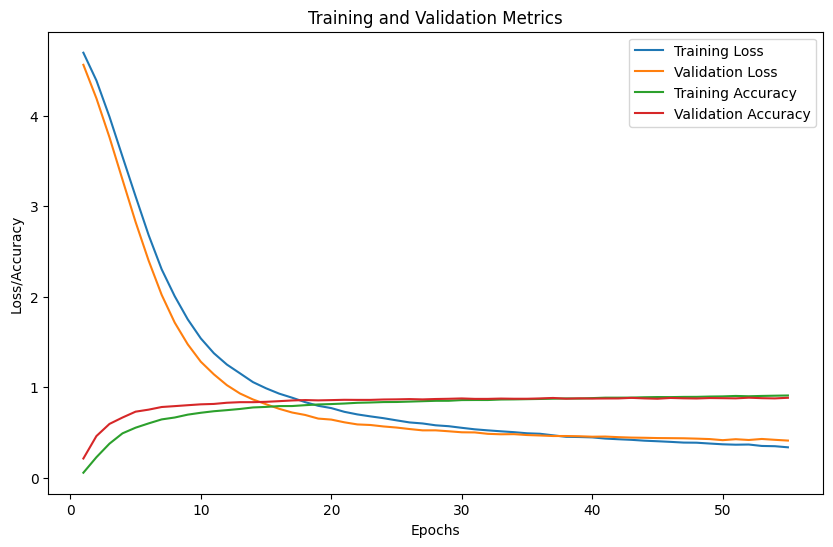

In [ ]:
# Load checkpoint
def plot_monitor(monitor):
  import matplotlib.pyplot as plt

  train_loss = monitor['train_loss']
  val_loss = monitor['val_loss']
  train_acc = monitor['train_acc']
  val_acc = monitor['val_acc']
  epochs = list(range(1, len(train_loss)+1))

  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.plot(epochs, train_acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Loss/Accuracy')
  plt.title('Training and Validation Metrics')
  plt.legend()

  plt.show()

checkpoint = torch.load('/content/checkpoint/default_checkpoint.ckpt')
print("Checkpoint includes:", checkpoint.keys())
plot_monitor(checkpoint['monitor_dict'])

In [ ]:
# Resume training from checkpoint, all layers are unfreeze in this step
trainer.load_checkpoint(model, checkpoint)
model.unfreeze_all_layers()
batch_size = 64
training_set_loader, validation_set_loader, testing_set_loader, dataset = get_data_loaders(images_path, factor_splits, batch_size, threads, mean, std, seed)
trainer.fit(model, training_set_loader, validation_set_loader)

Using 1 GPUs
[train] Epoch 56/100 

Loss: 0.34 Accuracy: 0.90
[val] Epoch 56/100 

Loss: 0.35 Accuracy: 0.90
[train] Epoch 57/100 

Loss: 0.26 Accuracy: 0.92
[val] Epoch 57/100 

Loss: 0.34 Accuracy: 0.90
[train] Epoch 58/100 

Loss: 0.22 Accuracy: 0.93
[val] Epoch 58/100 

Loss: 0.33 Accuracy: 0.90
[train] Epoch 59/100 

Loss: 0.18 Accuracy: 0.95
[val] Epoch 59/100 

Loss: 0.32 Accuracy: 0.90
[train] Epoch 60/100 

Loss: 0.16 Accuracy: 0.96
[val] Epoch 60/100 

Loss: 0.33 Accuracy: 0.90
[train] Epoch 61/100 

Loss: 0.13 Accuracy: 0.96
[val] Epoch 61/100 

Loss: 0.33 Accuracy: 0.89
[train] Epoch 62/100 

Loss: 0.12 Accuracy: 0.97
[val] Epoch 62/100 

Loss: 0.34 Accuracy: 0.89
[train] Epoch 63/100 

Loss: 0.10 Accuracy: 0.97
[val] Epoch 63/100 

Loss: 0.33 Accuracy: 0.90
Epoch 00063: reducing learning rate of group 0 to 1.0000e-06.
[train] Epoch 64/100 

Loss: 0.09 Accuracy: 0.98
[val] Epoch 64/100 

Loss: 0.33 Accuracy: 0.90


DogClassification(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [ ]:
# Download checkpoint to finetune
! gdown 16EwrJ35m9z7J0EWZr9M2GYRdZlrqU7Bx -O checkpoint/

Downloading...
From: https://drive.google.com/uc?id=16EwrJ35m9z7J0EWZr9M2GYRdZlrqU7Bx
To: /content/checkpoint/default_checkpoint_unfreeze.ckpt
100% 289M/289M [00:03<00:00, 74.7MB/s]


In [ ]:
trainer.load_checkpoint(model, 'checkpoint/default_checkpoint_unfreeze.ckpt')

True

In [ ]:
pred, target = trainer.test(model, testing_set_loader)
print("\nAccuracy score:", accuracy_score(target, pred.argmax(1)))

100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


Accuracy score: 0.8887269193391643
